# Capstone Project: Social media sentiment analysis 
## Part 3a: Topic Modeling using LDA

In [8]:
#!pip install -U spacy
#!pip install pyLDAvis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

from gensim import corpora
from gensim.models import CoherenceModel, Word2Vec, LsiModel, KeyedVectors, fasttext,LdaModel
from gensim import matutils
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Enable logging for gensim - optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\frl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)
unable to import 'smart_open.gcs', disabling that module


# Preprocess Twitter comments for topic modeling

In [3]:
# Call data from Part 2
tweet_combined_clean=pd.read_csv('./dataset/tweet_combined_clean_v1.csv')
samsung_tweet_neg=pd.read_csv('./dataset/samsung_tweet_neg.csv')
samsung_tweet_pos=pd.read_csv('./dataset/samsung_tweet_pos.csv')

In [4]:
# Unlike VADER, topic modeling requires extensive data cleaning - Edit stopwords to exclude emotional words like 'like','love' and brand names 'Samsung', 'Apple', 'Huawei'

lemm = WordNetLemmatizer()

def text_processer(text):
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
        
    # 4. Remove stop words
    stop_words = set(stopwords.words("english"))
    stop_words.update(['samsung','huawei','apple','http','like','really','want','good','say','love','better','much',
                       'day','lol','well','need','could','take','twt','add','maxwinebach','nhlblackhawk','smtshepossa',
                       'niantichelp','recognised','view','great','doh','samsungmobile','okay','check','feel','always',
                       'yes','stop','even','every','already','u','something','go','see','sure','shit','said','https','com','www','hi','please','co','thanks','one',
                       'think','got','also', 'make','know','use', 'would','get','look','never','still','mtshepossa','akinjoshua',
                       'pay','using','time','b','c','d','e','f','g','h','i','ksvaljek', 'right', 'used','godissfroot','nhlblackhawks','http',
                       'j','k','l','n','m','o','p','q','r','s','t','u','v','w','x','y','z', 'sorry', 'part', 'u', 'let','as', 'saying', 'bit', 
                       'update', 'techquotesdaily','oh', 'yeah','frecowang', 'bts', 'pak','ok','fuck','come','thing','south','settle','level', 
                       'took','actually','stand','im','watch', 'jezdez','offby','dirtytesla','universeice','as', 'thank', 'thanks', 'seem', 'seems',
                        'way','put','made','thought', 'jack'])
    filtered_words=[w for w in words if not w in stop_words]

    # 5. Lemmatize words.
    lemmed_words = [lemm.lemmatize(i) for i in filtered_words]
    
    return (" ".join(lemmed_words))

In [5]:
# Initialise both types of vectorizer for comparison
cv = CountVectorizer(analyzer='word',       
                             min_df=10,
                            token_pattern='[a-zA-Z0-9]{3,}') #set number of characters to be more than 3 per word

tv = TfidfVectorizer(analyzer='word',       
                             min_df=10,
                            token_pattern='[a-zA-Z0-9]{3,}') #set number of characters to be more than 3 per word

## LDA Modeling

## Samsung topic modeling

In [45]:
tweet_samsung_clean=tweet_combined_clean[tweet_combined_clean['brand']==0]
tweet_samsung_words=tweet_samsung_clean['text'].apply(text_processer)

samsung_cv=cv.fit_transform(tweet_samsung_words)
samsung_tv=tv.fit_transform(tweet_samsung_words)

Mean number of words per tweet   :  48.0
Median number of words per tweet :  49.0


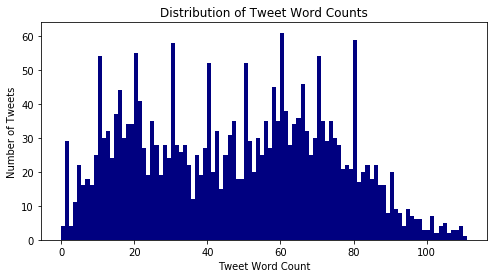

In [46]:
samsung_text_length=[len(d) for d in tweet_samsung_words];
# Plot
plt.figure(figsize=(8,4))
plt.hist(samsung_text_length, bins = 100, color='navy')
print("Mean number of words per tweet   : ", (round(np.mean(samsung_text_length))))
print("Median number of words per tweet : ", (round(np.median(samsung_text_length))))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

In [47]:
# LDA gridsearch with tfid vectorizer

# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_tv)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_tv))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -3338.778585698505
Model Perplexity:  235.81216268407195


In [48]:
# LDA gridsearch with countvectorizer

# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_cv)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_cv))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -5198.519598210621
Model Perplexity:  183.090851937965


Given the lower perlexity score, countvectorizer performs better with LSA compared to TFID vectorizer. This finding is in line with Blei (who developedLDA), he pointed out in the paper of 2003 ("LatentDirichlet Allocation) that LDA addresses the shortcomings of the TFID model and leaves this approach behind. LDA is a probabilistic model that tries to estimate probability distributions for topics in documnets and words in topics, the weighting of TFID is not necessary for this. LDA only needs a bag-of-word vector (aka CountVectorizer).

On a separate note, perplexity might not be the best measure to evaluate topic models because it doesnt consider the context and semantic associations between words. 

In [49]:
# Create function show top keywords for each topic
def show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [50]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(samsung_cv)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(tweet_samsung_clean['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()


0    1554
1     884
Name: dominant_topic, dtype: int64

In [51]:
# Topic-Keyword Matrix
df_topic_keywords_samsung = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_samsung.columns = cv.get_feature_names()
df_topic_keywords_samsung.index = topicnames

# View
df_topic_keywords_samsung.head()

,able,account,air,amazing,android,anything,app,apps,available,away,...,working,world,xbox,xiaomi,year,yet,youthpjjm,youtube,zareldo,zoneoftech
Topic0,13.259744,0.727356,1.744999,2.383816,65.948965,10.52086,46.594778,10.401123,9.356532,7.364671,...,1.544458,4.241432,3.316471,6.638334,46.952697,1.444924,8.056889,1.606066,0.578498,0.628296
Topic1,0.981998,10.523626,7.866699,7.431686,1.874435,1.58214,6.208578,0.822759,2.094757,1.680337,...,9.134430,6.398400,13.293578,2.385194,4.854752,8.396792,0.803935,8.860073,10.018176,17.936774


In [52]:
#Show top keywords
topic_keywords_samsung = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_samsung = pd.DataFrame(topic_keywords_samsung)
df_topic_keywords_samsung.columns = ['Word '+str(i) for i in range(df_topic_keywords_samsung.shape[1])]
df_topic_keywords_samsung.index = ['Topic '+str(i) for i in range(df_topic_keywords_samsung.shape[0])]

# Manually assign topics
df_topic_keywords_samsung['Topics']=['Samsung phone', 'phone issues']
df_topic_keywords_samsung

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,galaxy,iphone,android,plus,oneplus,year,app,work,new,help,series,smart,last,red,idea,Samsung phone
Topic 1,phone,note,samsungmobileus,bad,buy,user,shot,camera,channel,samsunguk,pro,iphone,price,screen,best,phone issues


In [53]:
samsung_vis=pyLDAvis.sklearn.prepare(best_lda_model, samsung_cv, cv)
pyLDAvis.save_html(samsung_vis, 'samsung_lda.html')
samsung_vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.181158  0.0       1        1  51.891794
1     -0.181158  0.0       2        1  48.108206, topic_info=                Term        Freq       Total Category  logprob  loglift
123            phone  233.000000  233.000000  Default  30.0000  30.0000
53            galaxy  196.000000  196.000000  Default  29.0000  29.0000
112             note   87.000000   87.000000  Default  28.0000  28.0000
4            android   76.000000   76.000000  Default  27.0000  27.0000
146  samsungmobileus   46.000000   46.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
151           screen   26.285107   38.745146   Topic2  -4.4162   0.3437
127             play   24.542972   36.740800   Topic2  -4.4848   0.3283
121           people   20.088200   26.309664   Topic2  -4.6851   0.4619
32            device   19.392732   28.862917   Topic2  -4.7203   0.3341
74            iphone   27.711871  116.235024   Topic2  -4.3634  -0.7020

[118 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.929852        able
0         2  0.061990        able
1         1  0.074846     account
1         2  0.972994     account
4         1  0.965476     android
...     ...       ...         ...
201       2  0.102104        year
205       1  0.079425     zareldo
205       2  0.953096     zareldo
206       1  0.045284  zoneoftech
206       2  0.950972  zoneoftech

[174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Apple topic modeling

In [54]:
tweet_apple_clean=tweet_combined_clean[tweet_combined_clean['brand']==1]
tweet_apple_words=tweet_apple_clean['text'].apply(text_processer)
apple_vectorized=cv.fit_transform(tweet_apple_words)

Mean number of words per tweet   :  50.0
Median number of words per tweet :  48.0


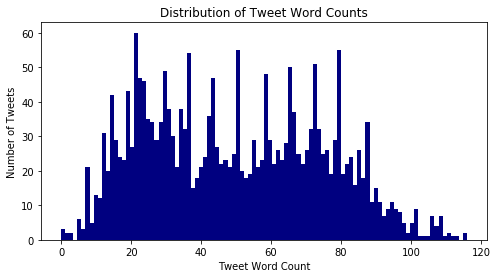

In [55]:
apple_text_length=[len(d) for d in tweet_apple_words];
# Plot
plt.figure(figsize=(8,4))
plt.hist(apple_text_length, bins = 100, color='navy')
print("Mean number of words per tweet   : ", (round(np.mean(apple_text_length))))
print("Median number of words per tweet : ", (round(np.median(apple_text_length))))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

In [56]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(apple_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(apple_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -3249.659401628509
Model Perplexity:  157.0304369748838


In [57]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(apple_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(tweet_apple_clean['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    1475
1     736
Name: dominant_topic, dtype: int64

In [58]:
# Topic-Keyword Matrix
df_topic_keywords_apple = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_apple.columns = cv.get_feature_names()
df_topic_keywords_apple.index = topicnames

# View
df_topic_keywords_apple.head()

,able,account,adair,adam,album,amazon,amazonin,android,anything,app,...,wish,without,word,work,working,world,worth,xikooba,year,yet
Topic0,5.126466,10.911530,0.871033,13.041078,4.273181,12.577188,0.827504,3.740868,6.918459,23.930214,...,16.964904,0.779624,9.470680,15.439089,0.900361,0.707972,9.386897,0.713963,2.675112,1.715506
Topic1,5.004846,1.491892,8.417374,1.140623,8.468265,0.798800,8.126772,17.116816,3.521358,18.267968,...,1.063364,7.941328,0.873712,2.258228,8.004314,8.098447,1.051256,10.270528,12.437271,7.181702


In [59]:
#Show top keywords
topic_keywords_apple = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_apple = pd.DataFrame(topic_keywords_apple)
df_topic_keywords_apple.columns = ['Word '+str(i) for i in range(df_topic_keywords_apple.shape[1])]
df_topic_keywords_apple.index = ['Topic '+str(i) for i in range(df_topic_keywords_apple.shape[0])]

# Manually assign topics
df_topic_keywords_apple['Topics']=['phone app', 'music streaming']
df_topic_keywords_apple

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,music,spotify,store,google,app,song,podcast,microsoft,available,eye,back,wish,link,pro,tidal,phone app
Topic 1,iphone,phone,new,people,product,big,best,song,app,android,help,buy,stream,realdonaldtrump,guy,music streaming


In [60]:
apple_vis=pyLDAvis.sklearn.prepare(best_lda_model, apple_vectorized, cv)
pyLDAvis.save_html(apple_vis, 'apple_lda.html')
apple_vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.185604  0.0       1        1  51.603996
1     -0.185604  0.0       2        1  48.396004, topic_info=        Term        Freq       Total Category  logprob  loglift
96     music  233.000000  233.000000  Default  30.0000  30.0000
127  spotify   73.000000   73.000000  Default  29.0000  29.0000
71    iphone   39.000000   39.000000  Default  28.0000  28.0000
107    phone   37.000000   37.000000  Default  27.0000  27.0000
106   people   29.000000   29.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
84      lmao   14.374909   16.512226   Topic2  -4.5792   0.5871
124     song   21.301281   47.238029   Topic2  -4.1859  -0.0707
9        app   21.225432   49.474339   Topic2  -4.1894  -0.1205
144   trying   14.632468   18.272713   Topic2  -4.5614   0.5036
162     year   14.450783   17.608673   Topic2  -4.5739   0.5281

[116 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         1  0.897135     adam
3         2  0.059809     adam
5         1  0.950864   amazon
5         2  0.063391   amazon
7         1  0.164583  android
...     ...       ...      ...
157       2  0.143890     work
161       1  0.078271  xikooba
161       2  0.939256  xikooba
162       1  0.170371     year
162       2  0.795063     year

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Huawei topic modeling

In [61]:
tweet_huawei_clean=tweet_combined_clean[tweet_combined_clean['brand']==2]
tweet_huawei_words=tweet_huawei_clean['text'].apply(text_processer)
huawei_vectorized=cv.fit_transform(tweet_huawei_words)

Mean number of words per tweet   :  57.0
Median number of words per tweet :  62.0


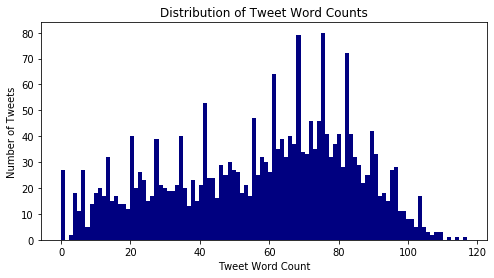

In [62]:
huawei_text_length=[len(d) for d in tweet_huawei_words];
# Plot
plt.figure(figsize=(8,4))
plt.hist(huawei_text_length, bins = 100, color='navy')
print("Mean number of words per tweet   : ", (round(np.mean(huawei_text_length))))
print("Median number of words per tweet : ", (round(np.median(huawei_text_length))))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.title('Distribution of Tweet Word Counts')
plt.show()

In [63]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(huawei_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(huawei_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -7305.12499617734
Model Perplexity:  236.6742562354973


In [64]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(huawei_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(tweet_huawei_clean['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    1533
1     871
Name: dominant_topic, dtype: int64

In [65]:
# Topic-Keyword Matrix
df_topic_keywords_huawei = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_huawei.columns = cv.get_feature_names()
df_topic_keywords_huawei.index = topicnames

# View
df_topic_keywords_huawei.head()

,accept,alghammer,amazing,america,american,amicuscelebrant,android,another,anyone,anything,...,western,wireless,work,working,world,wrong,xiaomi,year,yet,zoom
Topic0,9.359332,9.420200,7.208881,1.765534,4.617732,7.442782,0.877143,3.169382,18.043295,11.389814,...,3.855665,12.402901,21.243198,13.558050,44.311255,1.616216,12.834980,3.669200,1.185031,1.107089
Topic1,0.663772,0.838613,1.989785,20.156992,6.295317,2.494507,10.039514,6.743065,1.194088,10.524644,...,5.717159,1.606833,0.879990,0.766586,9.175159,12.176302,1.161667,26.032695,11.792961,17.852798


In [66]:
#Show top keywords
topic_keywords_huawei = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_huawei = pd.DataFrame(topic_keywords_huawei)
df_topic_keywords_huawei.columns = ['Word '+str(i) for i in range(df_topic_keywords_huawei.shape[1])]
df_topic_keywords_huawei.index = ['Topic '+str(i) for i in range(df_topic_keywords_huawei.shape[0])]

# Manually assign topics
df_topic_keywords_huawei['Topics']=['China communist party', 'China-US']
df_topic_keywords_huawei

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,china,chinese,canada,mask,company,globalnews,europe,pro,leeszla,world,communist,mike,government,sunlorrie,buy,China communist party
Topic 1,china,ccp,phone,people,country,virus,realdonaldtrump,technology,year,ttsampaio,device,america,tech,red,first,China-US


In [67]:
huawei_vis=pyLDAvis.sklearn.prepare(best_lda_model, huawei_vectorized, cv)
pyLDAvis.save_html(huawei_vis, 'huawei_lda.html')
huawei_vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.165053  0.0       1        1  55.295152
1     -0.165053  0.0       2        1  44.704848, topic_info=           Term        Freq       Total Category  logprob  loglift
33          ccp  101.000000  101.000000  Default  30.0000  30.0000
39      chinese  136.000000  136.000000  Default  29.0000  29.0000
173       phone  104.000000  104.000000  Default  28.0000  28.0000
29       canada   95.000000   95.000000  Default  27.0000  27.0000
91   globalnews   89.000000   89.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
197        real   19.475806   22.042491   Topic2  -4.9302   0.6813
234  technology   34.720896   51.309834   Topic2  -4.3521   0.4145
36        china  106.823855  283.976462   Topic2  -3.2282  -0.1726
94       google   21.771244   29.523849   Topic2  -4.8188   0.5005
47     contract   19.328555   24.547798   Topic2  -4.9378   0.5660

[116 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         1  0.075982  america
3         2  0.911783  america
19        1  0.960952  believe
19        2  0.041781  believe
22        1  0.050988    boris
...     ...       ...      ...
268       2  0.180760    world
271       1  0.112501     year
271       2  0.871885     year
273       1  0.043859     zoom
273       2  0.964905     zoom

[170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

Despite its great results on medium or large sized texts (>50 words), typically mails and news articles are about this size range, LDA poorly performs on short texts like Tweets. The assumption that a text is a mixture of topics is not true anymore. We will now assume that a short text is made from only one topic.

## Topic modeling on negative samsung tweets

In [68]:
samsung_tweet_neg_words=samsung_tweet_neg['text'].apply(text_processer)
samsung_tweet_neg_vectorized=cv.fit_transform(samsung_tweet_neg_words)

In [69]:
len(samsung_tweet_neg_words)

394

In [70]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_tweet_neg_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=5,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=42,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                              

In [71]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_tweet_neg_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -124.26195401445341
Model Perplexity:  13.159379317174055


In [72]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(samsung_tweet_neg_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(samsung_tweet_neg['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    344
1     50
Name: dominant_topic, dtype: int64

In [73]:
# Topic-Keyword Matrix
df_topic_keywords_samsung_neg = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_samsung_neg.columns = cv.get_feature_names()
df_topic_keywords_samsung_neg.index = topicnames

# View
df_topic_keywords_samsung_neg.head()

,android,bad,buy,company,galaxy,iphone,oneplus,phone,problem,product,series
Topic0,5.041988,1.207178,1.328709,1.259437,13.367322,7.490961,1.287767,11.484292,6.566559,0.761515,1.430104
Topic1,1.491714,9.641013,3.602012,4.272512,1.477771,3.584046,10.677234,2.647884,1.076500,3.840684,3.402030


In [74]:
#Show top keywords
topic_keywords_samsung_neg = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_samsung_neg = pd.DataFrame(topic_keywords_samsung_neg)
df_topic_keywords_samsung_neg.columns = ['Word '+str(i) for i in range(df_topic_keywords_samsung_neg.shape[1])]
df_topic_keywords_samsung_neg.index = ['Topic '+str(i) for i in range(df_topic_keywords_samsung_neg.shape[0])]

# Manually assign topics
#df_topic_keywords_samsung_neg['Topics']=['China communist party', 'China-US']
df_topic_keywords_samsung_neg

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,galaxy,phone,iphone,problem,android,series,buy,oneplus,company,bad,product
Topic 1,oneplus,bad,company,product,buy,iphone,series,phone,android,galaxy,problem


In [75]:
samsung_neg_vis=pyLDAvis.sklearn.prepare(best_lda_model, samsung_tweet_neg_vectorized, cv)
pyLDAvis.save_html(samsung_neg_vis, 'samsungneg_lda.html')
samsung_neg_vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.119284  0.0       1        1  52.491106
1     -0.119284  0.0       2        1  47.508894, topic_info=       Term       Freq      Total Category  logprob  loglift
6   oneplus  26.000000  26.000000  Default  11.0000  11.0000
4    galaxy  32.000000  32.000000  Default  10.0000  10.0000
1       bad  23.000000  23.000000  Default   9.0000   9.0000
7     phone  30.000000  30.000000  Default   8.0000   8.0000
8   problem  16.000000  16.000000  Default   7.0000   7.0000
9   product  10.000000  10.000000  Default   6.0000   6.0000
3   company  12.000000  12.000000  Default   5.0000   5.0000
2       buy  10.000000  10.000000  Default   4.0000   4.0000
0   android  14.000000  14.000000  Default   3.0000   3.0000
10   series  10.000000  10.000000  Default   2.0000   2.0000
5    iphone  24.000000  24.000000  Default   1.0000   1.0000
4    galaxy  29.038688  32.294613   Topic1  -1.3434   0.5383
8   problem  14.264955  16.636772   Topic1  -2.0543   0.4907
7     phone  24.948061  30.782058   Topic1  -1.4953   0.4344
0   android  10.953032  14.239677   Topic1  -2.3184   0.3821
5    iphone  16.273094  24.169707   Topic1  -1.9225   0.2489
10   series   3.106705  10.602288   Topic1  -3.5785  -0.5830
2       buy   2.886439  10.822635   Topic1  -3.6520  -0.6771
3   company   2.735955  12.149442   Topic1  -3.7056  -0.8463
9   product   1.654287  10.116342   Topic1  -4.2087  -1.1663
1       bad   2.622430  23.864163   Topic1  -3.7480  -1.5638
6   oneplus   2.797499  26.322304   Topic1  -3.6833  -1.5972
6   oneplus  23.524804  26.322304   Topic2  -1.4543   0.6319
1       bad  21.241733  23.864163   Topic2  -1.5564   0.6278
9   product   8.462055  10.116342   Topic2  -2.4767   0.5657
3   company   9.413487  12.149442   Topic2  -2.3702   0.4891
2       buy   7.936197  10.822635   Topic2  -2.5409   0.4340
10   series   7.495582  10.602288   Topic2  -2.5980   0.3975
5    iphone   7.896613  24.169707   Topic2  -2.5459  -0.3744
0   android   3.286645  14.239677   Topic2  -3.4225  -0.7219
7     phone   5.833997  30.782058   Topic2  -2.8486  -0.9190
8   problem   2.371817  16.636772   Topic2  -3.7487  -1.2037
4    galaxy   3.255924  32.294613   Topic2  -3.4319  -1.5502, token_table=      Topic      Freq     Term
term                          
0         1  0.772489  android
0         2  0.210679  android
1         1  0.125712      bad
1         2  0.879981      bad
2         1  0.277197      buy
2         2  0.739191      buy
3         1  0.246925  company
3         2  0.740775  company
4         1  0.897983   galaxy
4         2  0.092895   galaxy
5         1  0.661986   iphone
5         2  0.330993   iphone
6         1  0.113972  oneplus
6         2  0.911774  oneplus
7         1  0.812161    phone
7         2  0.194919    phone
8         1  0.841509  problem
8         2  0.120216  problem
9         1  0.197700  product
9         2  0.790800  product
10        1  0.282958   series
10        2  0.660235   series, R=11, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Topic modeling on positive samsung tweets

In [76]:
samsung_tweet_pos_words=samsung_tweet_pos['text'].apply(text_processer)
samsung_tweet_pos_vectorized=cv.fit_transform(samsung_tweet_pos_words)

In [77]:
len(samsung_tweet_pos_words)

965

In [78]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=42)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(samsung_tweet_pos_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(samsung_tweet_pos_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 2}
Best Log Likelihood Score:  -1099.888524623874
Model Perplexity:  58.92629617422572


In [79]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(samsung_tweet_pos_vectorized)

# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ['Doc' + str(i) for i in range(len(samsung_tweet_pos['text']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'].value_counts()

0    682
1    283
Name: dominant_topic, dtype: int64

In [80]:
# Topic-Keyword Matrix
df_topic_keywords_samsung_pos = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords_samsung_pos.columns = cv.get_feature_names()
df_topic_keywords_samsung_pos.index = topicnames

# View
df_topic_keywords_samsung_pos.head()

,android,app,best,bought,buy,camera,channel,device,fan,free,...,super,support,tablet,teejaye,tell,though,ultra,user,work,year
Topic0,17.733616,11.690529,8.926025,5.857205,11.175972,13.071953,0.900768,7.535584,7.223285,0.951122,...,2.207602,6.017030,6.538425,5.644857,5.620523,2.288227,1.438224,12.094725,11.373392,12.074274
Topic1,1.700982,7.400408,6.247578,1.616798,1.963529,1.710648,17.631742,1.479736,2.326615,9.698232,...,5.254587,1.374279,2.038070,1.290769,2.356971,5.263529,7.832247,1.412894,1.503271,2.621958


In [81]:
#Show top keywords
topic_keywords_samsung_pos = show_topics(vectorizer=cv, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords_samsung_pos = pd.DataFrame(topic_keywords_samsung_pos)
df_topic_keywords_samsung_pos.columns = ['Word '+str(i) for i in range(df_topic_keywords_samsung_pos.shape[1])]
df_topic_keywords_samsung_pos.index = ['Topic '+str(i) for i in range(df_topic_keywords_samsung_pos.shape[0])]

# Manually assign topics
df_topic_keywords_samsung_pos

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,phone,iphone,note,android,oneplus,pretty,camera,screen,user,year,app,work,samsungmobileus,buy,price
Topic 1,galaxy,smart,play,channel,new,pakistani,help,free,lite,ultra,going,plz,pakistan,guy,app


In [82]:
samsung_pos_vis=pyLDAvis.sklearn.prepare(best_lda_model, samsung_tweet_pos_vectorized, cv)
pyLDAvis.save_html(samsung_pos_vis, 'samsungpos_lda.html')
samsung_pos_vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.154464  0.0       1        1  55.011424
1     -0.154464  0.0       2        1  44.988576, topic_info=       Term        Freq       Total Category  logprob  loglift
10   galaxy   82.000000   82.000000  Default  30.0000  30.0000
34    phone  102.000000  102.000000  Default  29.0000  29.0000
47    smart   38.000000   38.000000  Default  28.0000  28.0000
19   iphone   45.000000   45.000000  Default  27.0000  27.0000
6   channel   29.000000   29.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
53     tell    3.761896   11.640377   Topic2  -4.9538  -0.3308
8       fan    3.713445   13.838572   Topic2  -4.9668  -0.5167
12     give    3.957021   15.634546   Topic2  -4.9032  -0.5752
58     year    4.184833   21.109760   Topic2  -4.8473  -0.8195
34    phone    5.469400  102.364369   Topic2  -4.5796  -2.1306

[95 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.906694  android
0         2  0.108803  android
1         1  0.567404      app
1         2  0.425553      app
2         1  0.578202     best
...     ...       ...      ...
56        2  0.104120     user
57        1  0.872324     work
57        2  0.109041     work
58        1  0.805315     year
58        2  0.189486     year

[118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])